# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [171]:
import pandas as pd  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model
from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF

from sklearn.metrics import mean_squared_error

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

The Number of observation in total data= 1119


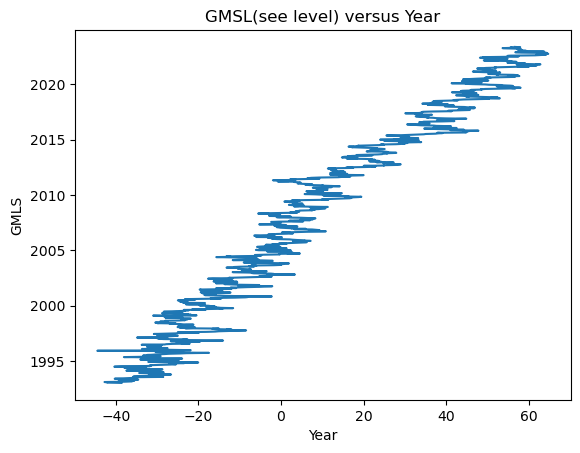

In [153]:
# Read CSV file into DataFrame
data = pd.read_csv('sealevel.csv')
obs_number=data.shape
print("The Number of observation in total data=",obs_number[0])
p=list(data.columns)
#print(p)
# storing in new variable 
#data_top = df.head() 
GMSL=data["GMSL"]
Year=data["Year"]
plt.plot(GMSL,Year)
plt.xlabel('Year')
plt.ylabel('GMLS')
plt.title("GMSL(see level) versus Year")

plt.show()

# display 
#data_top 

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** Auto regressive (AR) models assume that the data is stationary,which indicates that its statistical characteristics, like mean and variance, remain constant over time. But if a clear upward trend is present in the data, the mean of the data is not constant over time, opposing the stationarity assumption. Detrending the data helps make it stationary and guaranties that the AR model will be able to capture the temporal dependencies without being influenced by the trend.

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

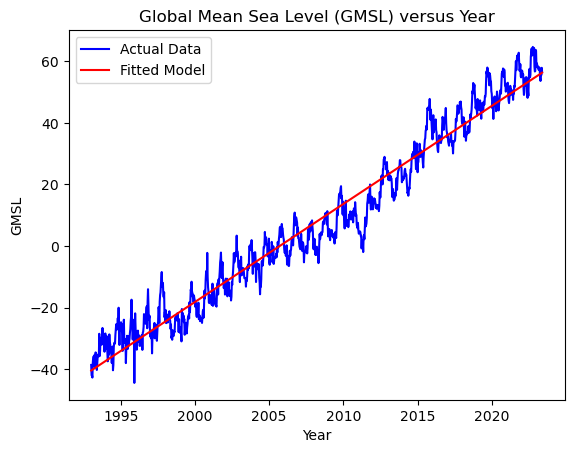

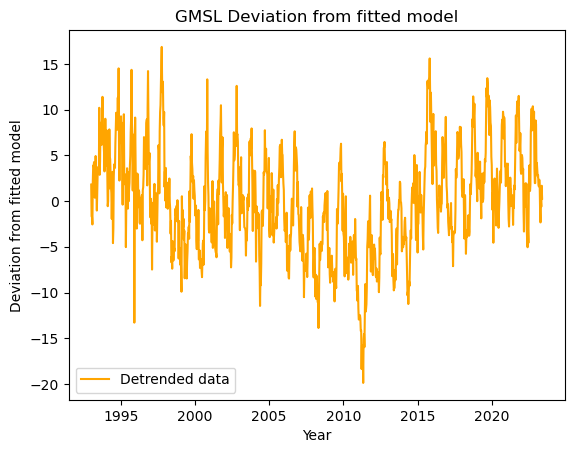

In [154]:
## Part 1
# returns a pandas DataFrame with one column, which is a two-dimensional data structure
#GMSL = data[["GMSL"]]
Year = data[["Year"]]
# Fit a straight line to the data based on the method of least squares
model = lm.LinearRegression().fit(Year, GMSL)

# Predict the values of the fitted line
fitted_model = model.predict(Year)


# Plotting the actual data and the fitted line
plt.plot(Year, GMSL, color = "blue", label="Actual Data")
plt.plot(Year, fitted_model, color = "red", label = "Fitted Model")
plt.xlabel("Year")
plt.ylabel("GMSL")
plt.title("Global Mean Sea Level (GMSL) versus Year")
plt.legend()
plt.show()


## Part 2
#Subtract the fitted line from 𝑦𝑡 (GMSL actual data) and determine their diviations (Detrending Data)
detrended_data = GMSL - fitted_model

# Plotting the deviations from the straight line
plt.plot(Year, detrended_data, color = "orange", label = "Detrended data")
plt.xlabel("Year")
plt.ylabel("Deviation from fitted model")
plt.title("GMSL Deviation from fitted model")
plt.legend()
plt.show()



**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

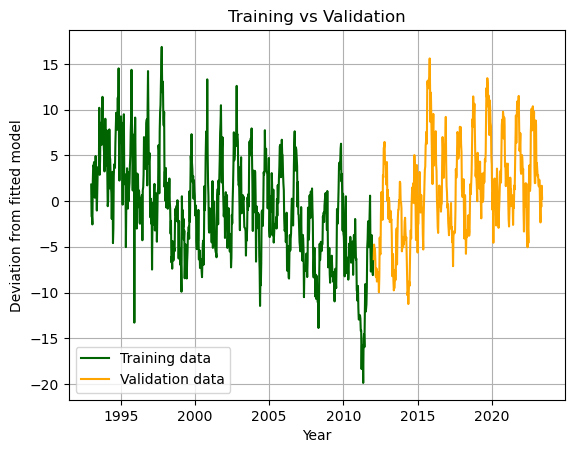

In [155]:
# we define varible asa 700th time point
tp = 700

# Split the detrended data into training and validation sets
train = detrended_data[:tp]
valid = detrended_data[tp:]

# Convert train and valid to NumPy arrays with the same data type (e.g., float64)
#train = np.array(train, dtype=np.float64)
#valid = np.array(valid, dtype=np.float64)

# Selecting corresponding Year
train_Year = Year[:tp]
valid_Year = Year[tp:]

# Plotting the two data sets (Train & Validation)
# Plotting Training data
plt.plot(train_Year, train, color = "darkgreen", label = "Training data")
# Plotting Validation data
plt.plot(valid_Year, valid, color = "orange", label = "Validation data")

plt.xlabel("Year")
plt.ylabel("Deviation from fitted model")
plt.title("Training vs Validation")
plt.legend()
plt.grid(True)
plt.show()



## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [156]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = y.shape[0] # <COMPLETE THIS LINE>
    
    # Construct the regression matrix
    Phi = np.zeros((n-p,p))
                   
                   
    for j in range(p):
        #Phi[:,j] =y[p-j-1:n-j] # <COMPLETE THIS LINE>
        Phi[:,j] =y[p-j-1:n-j-1] # <COMPLETE THIS LINE>
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

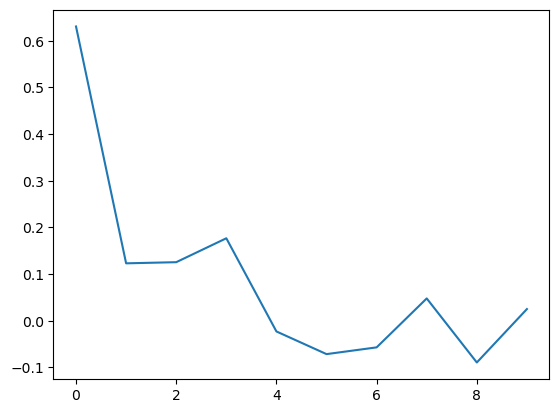

In [157]:
theta=fit_ar(train, 10)
theta
plt.plot(theta)

**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [158]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = len(theta)
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m)
    
    for i in range(m):
        # <COMPLETE THIS CODE BLOCK>
        y_pred[i] = np.dot(theta, y_target[i:i+p][::-1]) # <COMPLETE THIS LINE> #
        
    return y_pred

In [159]:
y = predict_ar_1step(theta, np.concatenate((train,valid)))
p=10
y_train_pred = y[:len(train) - p]
y_valid_pred = y[len(train) - p:]


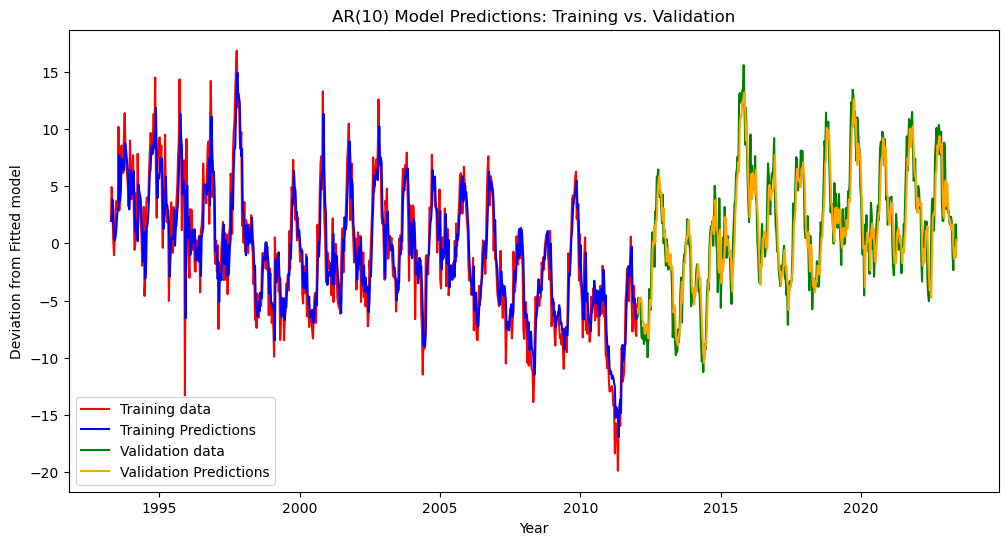

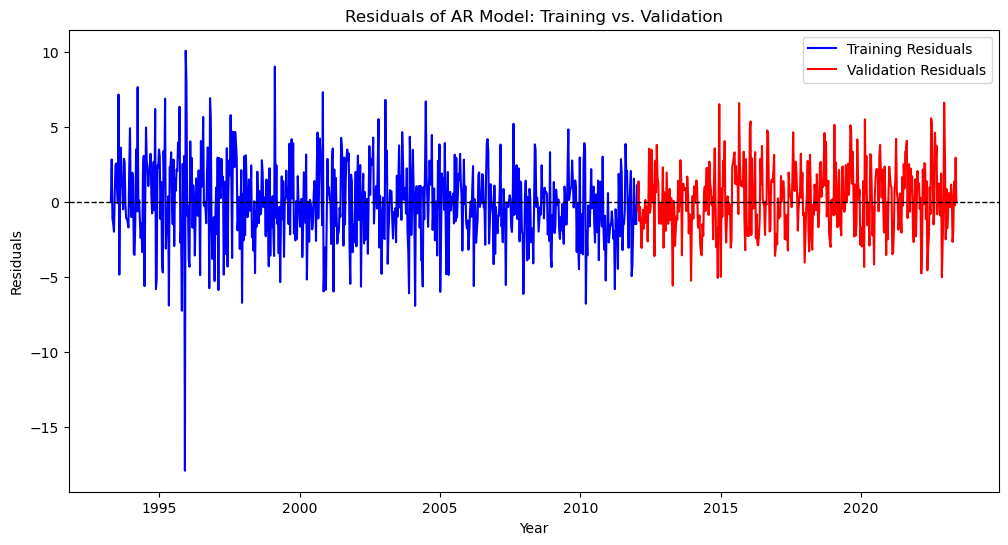

In [160]:
# Plot the training data, training predictions, validation data, and validation predictions
Year = data["Year"]
# Selecting corresponding Year
train_Year = Year[:tp]
valid_Year = Year[tp:]

plt.figure(figsize=(12, 6))
plt.plot(train_Year[p:], train[p:], color="red", label="Training data")
plt.plot(train_Year[p:], y_train_pred, color="blue", label="Training Predictions")
plt.plot(valid_Year, valid, color="green", label="Validation data")
plt.plot(valid_Year, y_valid_pred, color="orange", label="Validation Predictions")

plt.xlabel("Year")
plt.ylabel("Deviation from Fitted model")
plt.title("AR(10) Model Predictions: Training vs. Validation")
plt.legend()
plt.show()

# Calculate and plot the residuals
residuals_train = train[p:] - y_train_pred
residuals_valid = valid - y_valid_pred

plt.figure(figsize=(12, 6))
plt.plot(train_Year[p:], residuals_train, color="blue", label="Training Residuals")
plt.plot(valid_Year, residuals_valid, color="red", label="Validation Residuals")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.title("Residuals of AR Model: Training vs. Validation")
plt.legend()
plt.show()

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

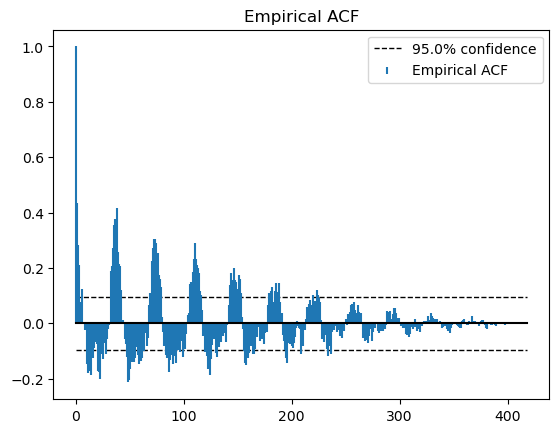

In [161]:
# help(acfplot)

# Computing the autocorrelation function (ACF) of the residuals
#residuals_valid.shape
# lags is the maximum lag to compute the ACF for. If None, this is set to n-1. Default is None.

ACF = acf(residuals_valid)
#print("Autocorrelation function(ACF) of the residuals is equal=", ACF)

# Plot the ACF of the residuals
acfplot(ACF)

# Here we can see the sin pattern in ACF that shows, we have a seasonality at the positive and negative peaks of the sinusoidal ACF. 
#Also the peaks has decayed in each peak and the most values are within the confidence intervals so it can be concluded that  the AR(10) model has captured most of the temporal dependencies in the data.

The ACF plot starts with a significant positive autocorrelation approximately 0.4 and a negative autocorrelation approximately -0.2. This suggests that there is some short-term autocorrelation in our time series data, meaning that each observation is moderately correlated with its immediate neighbors in both positive and negative directions. 
The pattern of decreasing autocorrelation indicates that the influence of past observations on future observations diminishes as the time lag increases. 
There is autocorrelation in our time series data, but this autocorrelation diminishes as the lag increases, and there is no strong evidence of autocorrelation beyond a lag of 200.

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

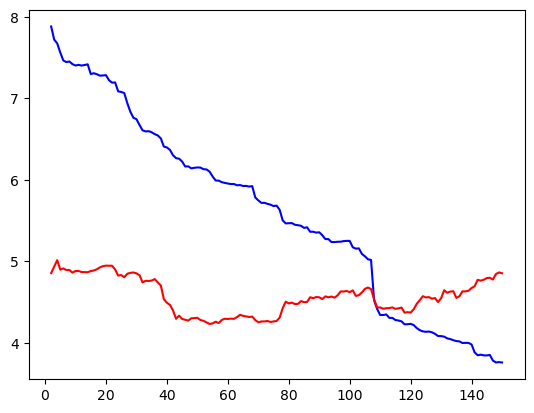

In [162]:
p_range = range(2,151)

MSE_train=[]
MSE_valid=[]

for p in p_range:
    theta=fit_ar(train,p)
    y = predict_ar_1step(theta, np.concatenate((train,valid)))
    
    y_train_pred = y[:len(train) - p]
    y_valid_pred = y[len(train) - p:]
    
    y_true_train=train[p:]
    y_true_valid=valid
    
    mse_t=mean_squared_error(y_true_train, y_train_pred)
    MSE_train.append(mse_t)
    
    mse_v=mean_squared_error(y_true_valid,y_valid_pred)
    MSE_valid.append(mse_v)
    
plt.plot(p_range,MSE_train , color="blue", label="Training Residuals")
plt.plot(p_range,MSE_valid, color="red", label="Validation Residuals")

What is the main difference between the changes in training error and validation error as the order increases??
As the order increased, the validation error fell up to p=41 and then climbed with a modest slope, whereas the train error gradually declined as the order increased. 

Based on these results, which model order would you suggest to use and why?
Based on the above results, we suggest p = 41

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

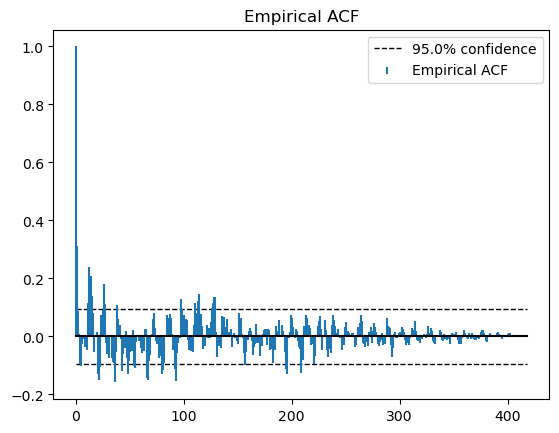

In [163]:
# Our chosen model order : p=41
p=41
# Calculate and plot the residuals of one-step-ahead predictions on the validation
theta=fit_ar(train,p)
y = predict_ar_1step(theta, np.concatenate((train,valid)))
    
#y_train_pred = y[:len(train) - p]
y_valid_opt_pred = y[len(train) - p:]
    
#y_true_train=train[p:]
y_true_valid=valid

residuals_opt_valid = y_true_valid - y_valid_opt_pred

# Calculate the autocorrelation function of the residuals
ACF1 = acf(residuals_opt_valid)

# Plot the ACF of the residuals
acfplot(ACF1)

This ACF plot significantly better than the one for p=10, because most values are within the confidence intervals (dashed lines)

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [164]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """
    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point

    for i in range(m):
        y_sim[i] = np.dot(phi, theta)   # <COMPLETE THIS LINE>
        # <COMPLETE THIS CODE BLOCK>
        phi = np.roll(phi, shift=-1)
        phi[-1] = y_sim[i]
        
    return y_sim
    

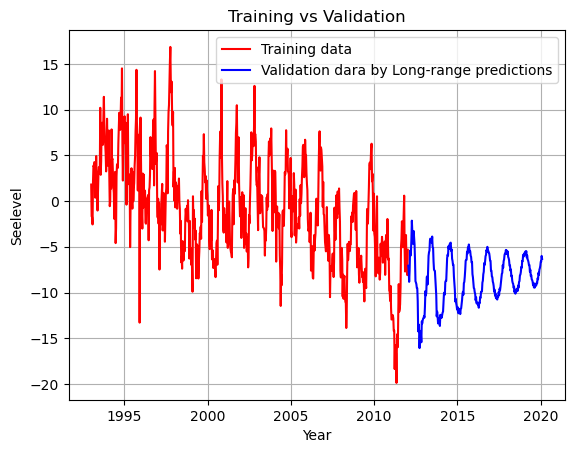

In [169]:
valid_new = simulate_ar(train, theta, 297)

tp=700
train[:700].shape
train_Year = Year[:700]
valid_Year = Year[700:700+297]
plt.plot(Year[:tp],train[:tp], color="red", label="Training data")
plt.plot(valid_Year,valid_new, color="blue", label="Validation dara by Long-range predictions")
plt.xlabel("Year")
plt.ylabel("Seelevel")
plt.title("Training vs Validation")
plt.legend()
plt.grid(True)
plt.show()

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

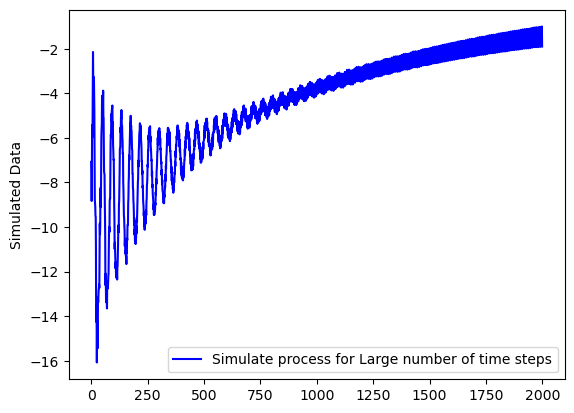

In [166]:
# Create an array of time steps from 701 to 2700
#time_steps = range(701, 2701)

# Simulate the AR process with 2000 time steps
simulated_data = simulate_ar(train, theta, 2000)

# Plot the simulated data
plt.plot(simulated_data, color="blue", label="Simulate process for Large number of time steps")

# Add labels and legend
#plt.xlabel("Time Steps")
plt.ylabel("Simulated Data")
plt.legend()
plt.show()

Is this something that you would expect to see in general? Explain the result: We can see that the predicted values eventually converge to a constant prediction of zero. We expected this because at the first step we detrend tha data that means modeling and removing long-term trends or constant components.

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

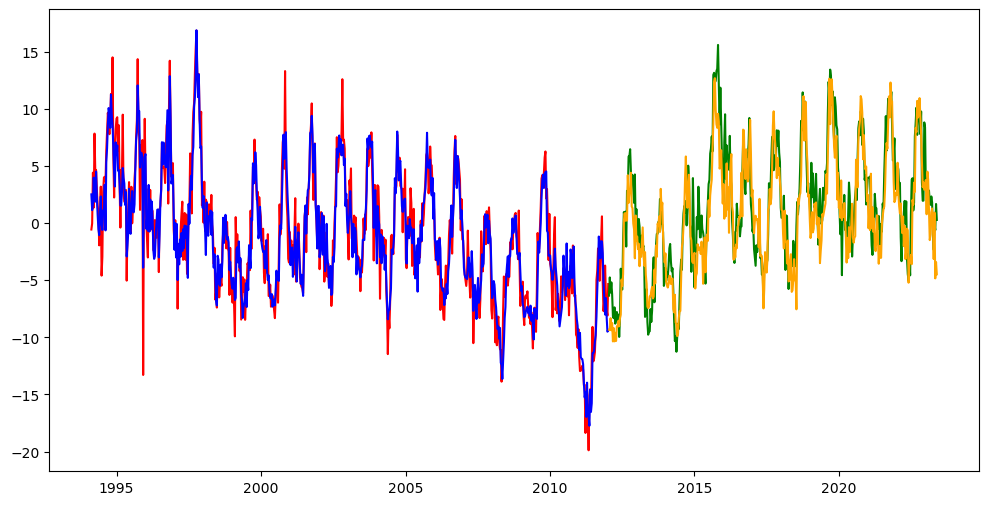

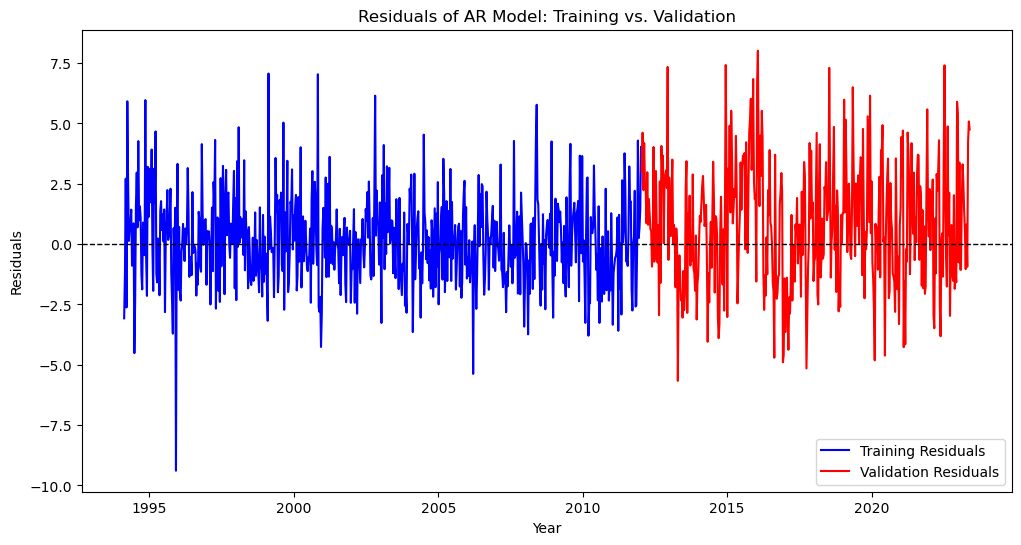

In [167]:
p=41

def create_lagged_sequences(y, p):
    # Number of training data points
    n = y.shape[0] # <COMPLETE THIS LINE>
    # Construct the regression matrix
    Phi = np.zeros((n-p,p))               
    for j in range(p):
        #Phi[:,j] =y[p-j-1:n-j] # <COMPLETE THIS LINE>
        Phi[:,j] =y[p-j-1:n-j-1] # <COMPLETE THIS LINE>
    return Phi
        

Phi_train = create_lagged_sequences(train, p)  
#print(X_train.shape)
NAR = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=1000, random_state=41, 
                   learning_rate_init=0.01) 
yy = train[p:] 
model=NAR.fit(Phi_train,yy)

Phi_test = create_lagged_sequences(detrended_data, p)
y_predict=model.predict(Phi_test)

Year = data["Year"]
# Selecting corresponding Year
train_Year = Year[:tp]
valid_Year = Year[tp:]

y_train_pred= y_predict[:len(train) - p]
y_valid_pred = y_predict[len(train) - p:]

plt.figure(figsize=(12, 6))
plt.plot(train_Year[p:], train[p:], color="red", label="Training data")
plt.plot(train_Year[p:], y_train_pred, color="blue", label="Training Predictions")
plt.plot(valid_Year, valid, color="green", label="Validation data")
plt.plot(valid_Year, y_valid_pred, color="orange", label="Validation Predictions")

plt.show()


# Calculate and plot the residuals
residuals_train = train[p:] - y_train_pred
residuals_valid = valid - y_valid_pred

plt.figure(figsize=(12, 6))
plt.plot(train_Year[p:], residuals_train, color="blue", label="Training Residuals")
plt.plot(valid_Year, residuals_valid, color="red", label="Validation Residuals")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.title("Residuals of AR Model: Training vs. Validation")
plt.legend()
plt.show()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**

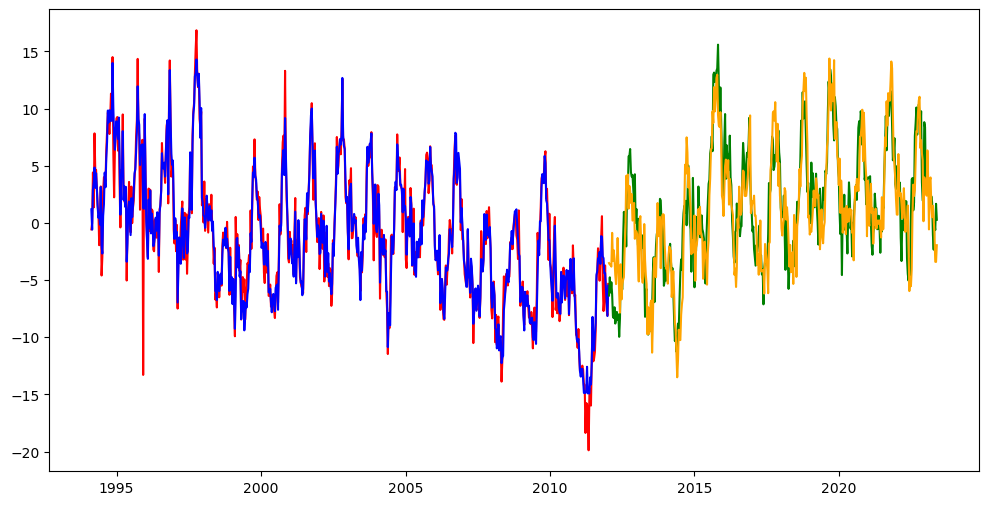

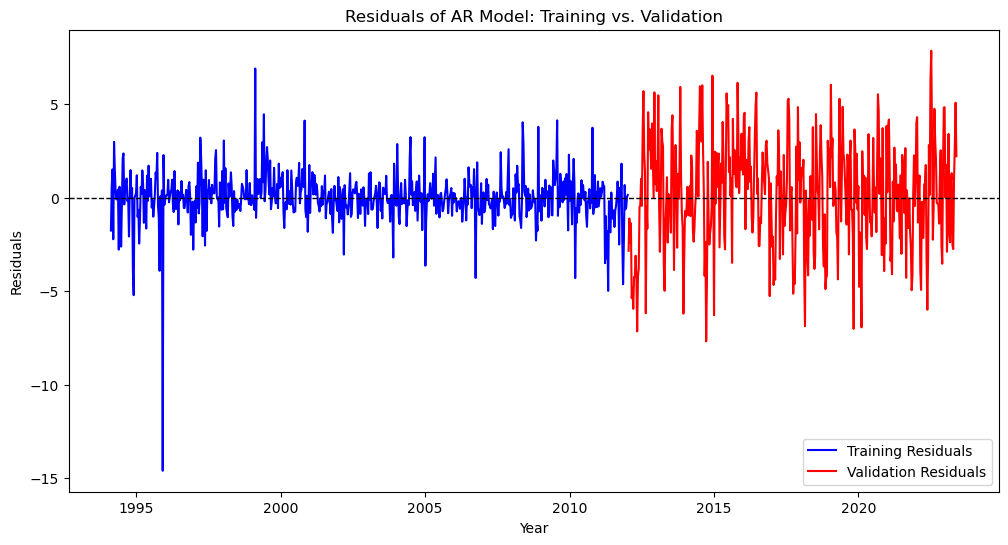

In [168]:
p=41

def create_lagged_sequences(y, p):
    # Number of training data points
    n = y.shape[0] # <COMPLETE THIS LINE>
    # Construct the regression matrix
    Phi = np.zeros((n-p,p))               
    for j in range(p):
        #Phi[:,j] =y[p-j-1:n-j] # <COMPLETE THIS LINE>
        Phi[:,j] =y[p-j-1:n-j-1] # <COMPLETE THIS LINE>
    return Phi
        

Phi_train = create_lagged_sequences(train, p)  
#print(X_train.shape)
NAR = MLPRegressor(hidden_layer_sizes=(20,), activation='tanh', solver='adam', max_iter=500, random_state=41, 
                   learning_rate_init=0.01) 
yy = train[p:] 
model=NAR.fit(Phi_train,yy)

Phi_test = create_lagged_sequences(detrended_data, p)
y_predict=model.predict(Phi_test)

Year = data["Year"]
# Selecting corresponding Year
train_Year = Year[:tp]
valid_Year = Year[tp:]

y_train_pred= y_predict[:len(train) - p]
y_valid_pred = y_predict[len(train) - p:]

plt.figure(figsize=(12, 6))
plt.plot(train_Year[p:], train[p:], color="red", label="Training data")
plt.plot(train_Year[p:], y_train_pred, color="blue", label="Training Predictions")
plt.plot(valid_Year, valid, color="green", label="Validation data")
plt.plot(valid_Year, y_valid_pred, color="orange", label="Validation Predictions")

plt.show()


# Calculate and plot the residuals
residuals_train = train[p:] - y_train_pred
residuals_valid = valid - y_valid_pred

plt.figure(figsize=(12, 6))
plt.plot(train_Year[p:], residuals_train, color="blue", label="Training Residuals")
plt.plot(valid_Year, residuals_valid, color="red", label="Validation Residuals")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.title("Residuals of AR Model: Training vs. Validation")
plt.legend()
plt.show()

We changed the activation function to "tanh" and increased the number of hidden lauer to 20, the residuals for training were significantly decreased, and the residual interval of the validation data was getting smaller compared to the previous condition. It should be noted that, when the activation function is "relu" and we increase the number of hidden layers, it does not affect very much. In addition, when the number of max_iter changed between 500 to 1000, there was not visible changes in result. Therefore, we reached the best result with "tanh" as a activation function, and hidden layer sizes = (20, ) and max_iter = 500.